In [1]:
from data import prices_NYSE, volume_NYSE, returns_NYSE
from data import prices_SIC, volume_SIC, returns_SIC, benchmark_SIC
from data import expected_return, total_return, daily_return

from functions import OptimizePortfolioWeights, optimize_lmda, random_portfolio_testing
from backtesting import backtesting

from visualizations import plot_prices, plot_volume, plot_pie, plot_backtesting, plot_simulation_hist, plot_boxplot
from visualizations import plot_efficient_frontier

import optuna
import pandas as pd

pd.options.display.float_format = '{:,.2f}'.format

In [45]:
import data

## Plotting Volume in Different Markets

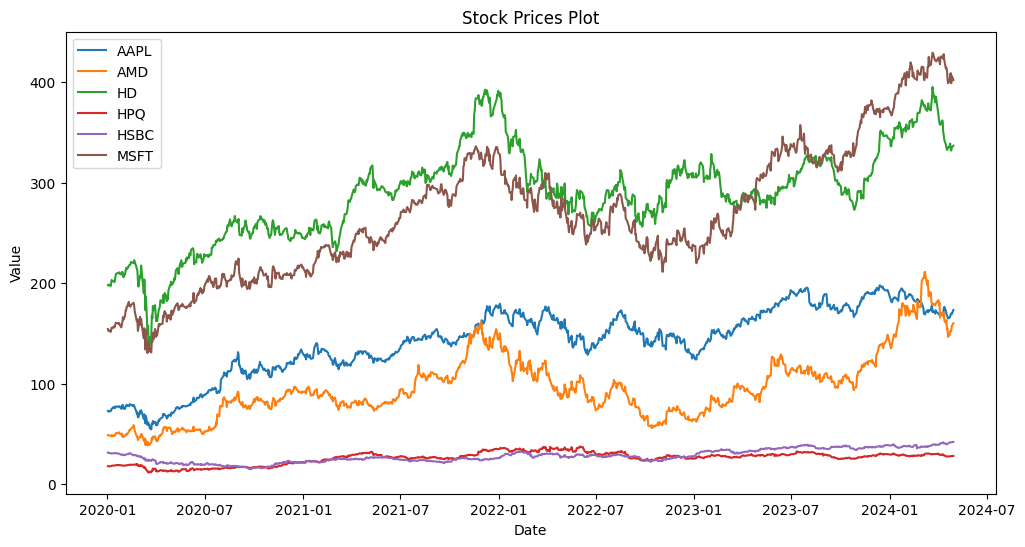

In [2]:
plot_prices(prices_NYSE)

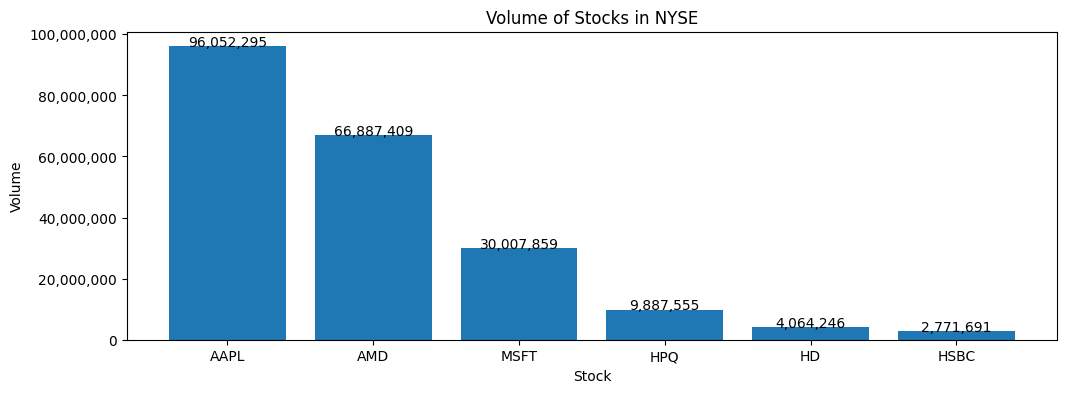

In [3]:
plot_volume(volume_NYSE.mean())

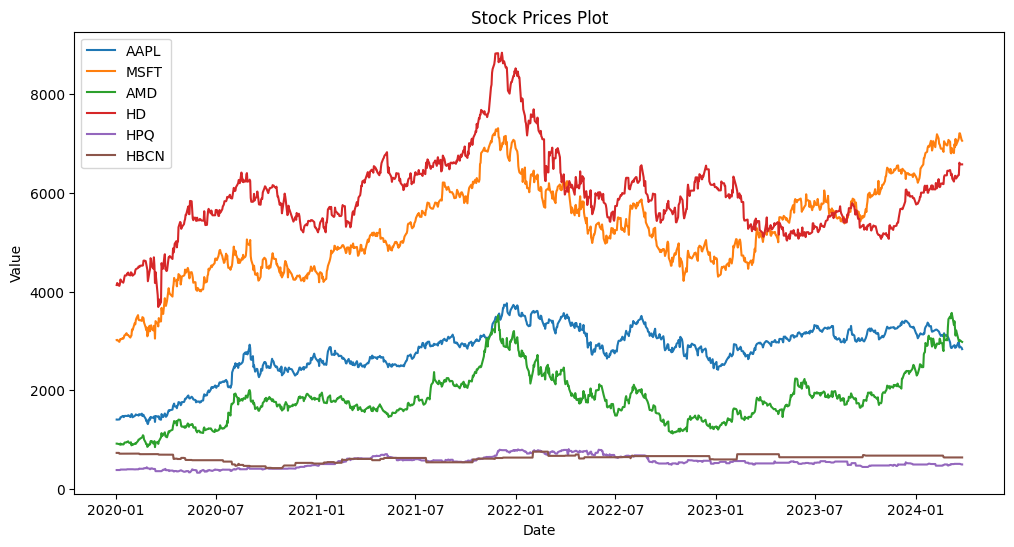

In [4]:
plot_prices(prices_SIC)

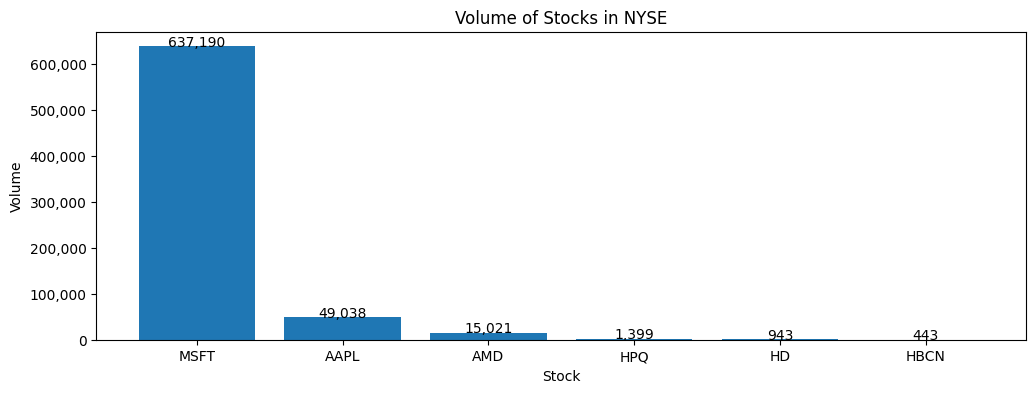

In [5]:
plot_volume(volume_SIC.mean())

## Kernel 1: Covariance 

In [6]:
capital, rf =1000000, 5.5/100

In [7]:
optuna.logging.disable_default_handler()
study_cov = optuna.create_study(direction="minimize")
study_cov.optimize(lambda trial: optimize_lmda(trial, prices_SIC, benchmark_SIC, volume_SIC.mean(), returns_SIC.cov(), capital, rf), n_trials=200)

In [8]:
study_cov.best_params, study_cov.best_value, study_cov.best_trial.user_attrs["weights"]

({'lam': 0.01920207540177079},
 -2921587.961829945,
 array([2.56781155e-02, 5.65526744e-01, 4.08795140e-01, 0.00000000e+00,
        6.59194921e-17, 3.90312782e-18]))

In [9]:
optimizer_1 = OptimizePortfolioWeights(returns=returns_SIC, kernel=returns_SIC.cov(), risk_free=rf)

In [10]:
w_1_covariance, _ = optimizer_1.sharpe_scipy()

w_1_covariance

array([0.01031001, 0.48052115, 0.34957633, 0.03344033, 0.12615218,
       0.        ])

In [11]:
w_2_covariance = study_cov.best_trial.user_attrs["weights"]

w_2_covariance

array([2.56781155e-02, 5.65526744e-01, 4.08795140e-01, 0.00000000e+00,
       6.59194921e-17, 3.90312782e-18])

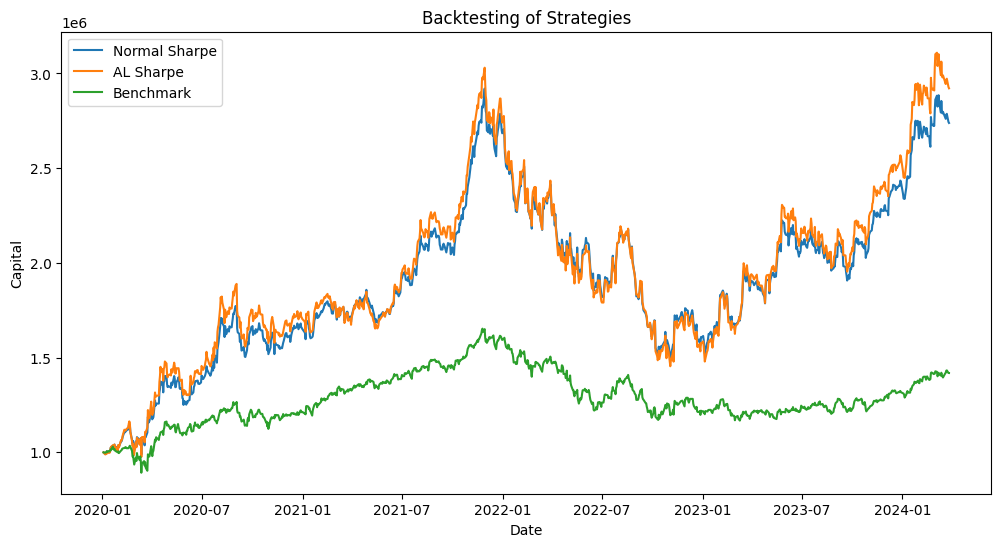

In [12]:
bt=backtesting(weights_summary=[w_1_covariance, w_2_covariance], 
               names=['Normal Sharpe', 'AL Sharpe'], 
               data_stocks=prices_SIC, data_benchmark=benchmark_SIC, cap_inicial=capital)

history=bt.history()

plot_backtesting(history)

In [13]:
bt.metrics(rf=5.5/100)

,Expected Return,Volatility,Sharpe,Downside,Upside,Omega,VaR 97.5%
Normal Sharpe,28.1494,29.3753,0.7710,1.0349,1.1837,1.1437,-3.3812
AL Sharpe,30.9171,33.3538,0.7620,1.1726,1.3530,1.1538,-3.9030


## Kernel 2:  Correlation 

In [23]:
study_corr = optuna.create_study(direction="minimize")
study_corr.optimize(lambda trial: optimize_lmda(trial, prices_SIC, benchmark_SIC, volume_SIC.mean(), returns_SIC.corr(), capital, rf), n_trials=200)

In [24]:
study_corr.best_params, study_corr.best_value, study_corr.best_trial.user_attrs["weights"]

({'lam': 9.767809095626115},
 -2333100.814565055,
 array([2.81008897e-12, 1.00000000e+00, 2.74594627e-12, 2.97344961e-12,
        0.00000000e+00, 0.00000000e+00]))

In [25]:
w_corr = study_corr.best_trial.user_attrs["weights"]

w_corr

array([2.81008897e-12, 1.00000000e+00, 2.74594627e-12, 2.97344961e-12,
       0.00000000e+00, 0.00000000e+00])

## Kernel 3: Trying Different Kernels

In [26]:
from functions import try_kernels

In [27]:
import numpy as np
import pandas as pd
import time


standarized_prices=pd.DataFrame(prices_SIC.values/np.max(prices_SIC.values, axis=0))

typ, best_kernel = try_kernels(standarized_prices, benchmark_SIC, volume_SIC.mean(), capital, rf)

In [28]:
typ, best_kernel

('ornstein_kernel_prices',
 [{'l': 5174.81758274566, 'lam': 48.800816963723236},
  -2333100.8179235286,
  array([0.00000000e+00, 1.00000000e+00, 4.42795245e-10, 0.00000000e+00,
         0.00000000e+00, 5.19647547e-10])])

In [29]:
from functions import ornstein_kernel

ornstein=ornstein_kernel(standarized_prices.T.values, l=best_kernel[0].get('l'))

pd.DataFrame(ornstein)

,0,1,2,3,4,5
0,1.0000,0.9871,0.9539,0.9776,0.9778,0.9762
1,0.9871,1.0000,0.9586,0.9836,0.9776,0.9718
2,0.9539,0.9586,1.0000,0.9655,0.9622,0.9373
3,0.9776,0.9836,0.9655,1.0000,0.9831,0.9638
4,0.9778,0.9776,0.9622,0.9831,1.0000,0.9658
5,0.9762,0.9718,0.9373,0.9638,0.9658,1.0000


In [30]:
ornstein_weights=best_kernel[2]
ornstein_weights

array([0.00000000e+00, 1.00000000e+00, 4.42795245e-10, 0.00000000e+00,
       0.00000000e+00, 5.19647547e-10])

## Comparing all the strategies

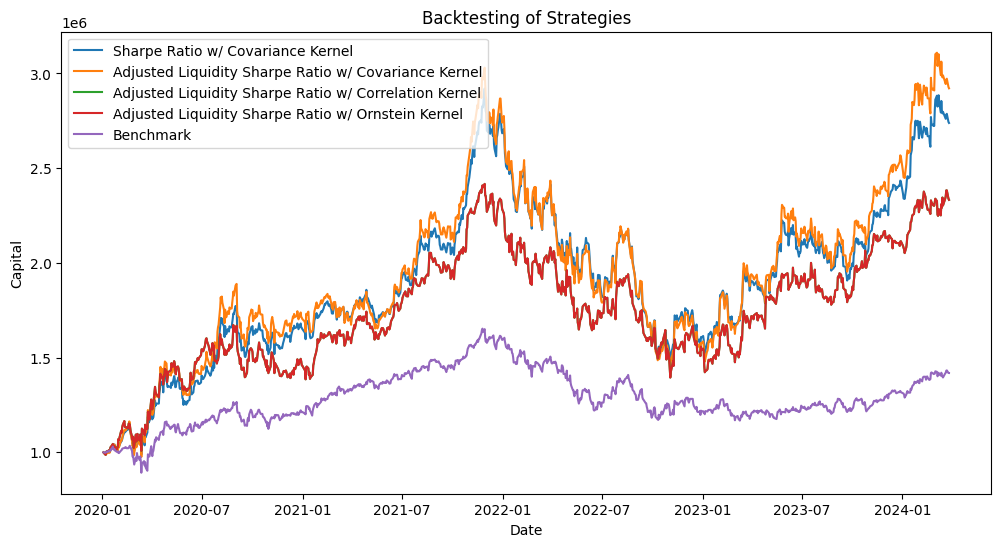

In [31]:
bt=backtesting(weights_summary=[w_1_covariance, w_2_covariance, w_corr, ornstein_weights], 
               names=['Sharpe Ratio w/ Covariance Kernel',
                      'Adjusted Liquidity Sharpe Ratio w/ Covariance Kernel', 
                      'Adjusted Liquidity Sharpe Ratio w/ Correlation Kernel',
                      'Adjusted Liquidity Sharpe Ratio w/ Ornstein Kernel'], 
               data_stocks=prices_SIC, data_benchmark=benchmark_SIC, cap_inicial=capital)


history=bt.history()

plot_backtesting(history)

In [32]:
bt.metrics(rf=5.5/100)

,Expected Return,Volatility,Sharpe,Downside,Upside,Omega,VaR 97.5%
Sharpe Ratio w/ Covariance Kernel,28.1494,29.3753,0.7710,1.0349,1.1837,1.1437,-3.3812
Adjusted Liquidity Sharpe Ratio w/ Covariance Kernel,30.9171,33.3538,0.7620,1.1726,1.3530,1.1538,-3.9030
Adjusted Liquidity Sharpe Ratio w/ Correlation Kernel,24.3115,29.2866,0.6423,1.0193,1.2190,1.1958,-3.4987
Adjusted Liquidity Sharpe Ratio w/ Ornstein Kernel,24.3115,29.2866,0.6423,1.0193,1.2190,1.1958,-3.4987


**Best Strategy: Adjusted by Liquidity Sharpe Ratio with Covariance Kernel**

## Adjusted by Liquidity Sharpe Ratio in the Efficient Frontier

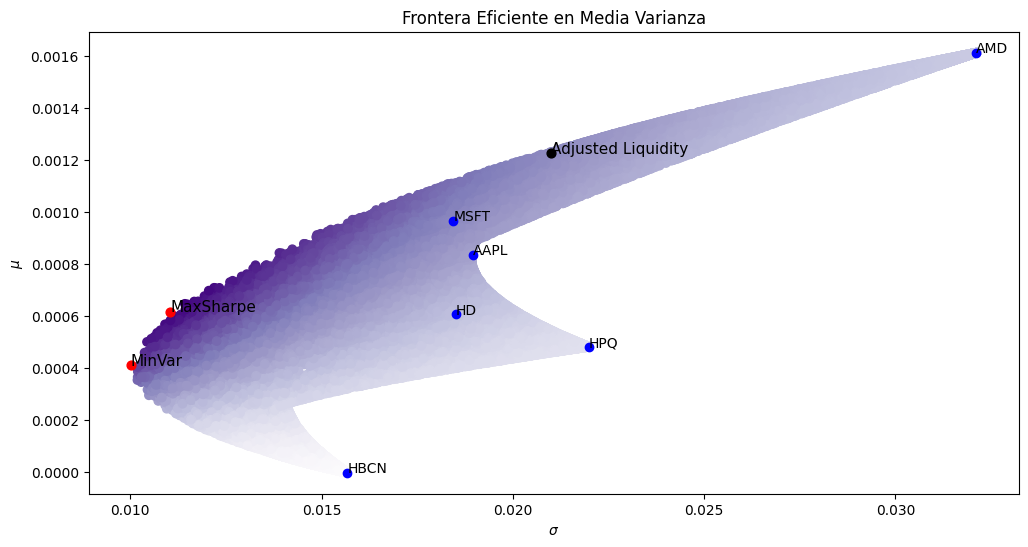

In [33]:
plot_efficient_frontier(returns_SIC, rf, w_2_covariance)

## Simulation of Random Portfolios Summary

In [34]:
sum(expected_return['Adjusted by Liquidity']> expected_return['Sharpe Ratio'])/len(expected_return)*100

69.08999999999999

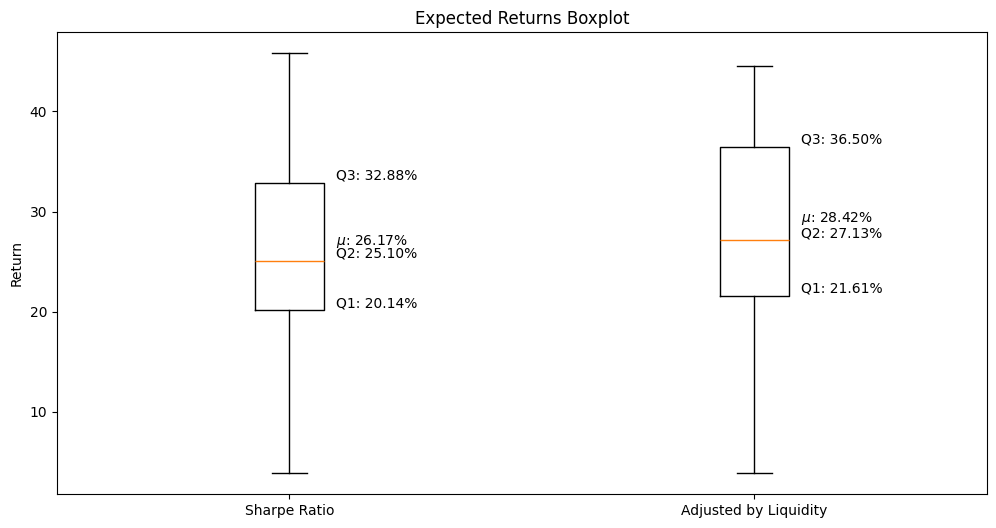

In [35]:
plot_boxplot(expected_return)

In [36]:
prices_SIC_2 = pd.read_excel('SIC_data/prices_2.xlsx', index_col=0)
volume_SIC_2 = pd.read_excel('SIC_data/volume_2.xlsx', index_col=0)
returns_SIC_2 = prices_SIC_2.pct_change().dropna()


means=volume_SIC_2.mean(axis=0)
tickers=means[np.percentile(means, 75)<means].index

data=prices_SIC_2[np.random.choice(tickers, 5)]
data_volume=volume_SIC_2[data.columns]


months=3
capital=1000000
rf=0.055

In [37]:
class dynamic_backtesting:
    
    def __init__(self, prices, volume, capital, rf, months):
        
        self.prices=prices
        self.volume=volume
        self.months=months
        self.capital=capital
        self.rf=rf
        
    
    def optimize_weights(self, prices: pd.DataFrame, volume: pd.DataFrame, n_sims: int,
                         n_days: int, periods: int):

        temp_data=prices.iloc[int(n_days*periods):int(n_days*(periods+1)), :]
        temp_rets = temp_data.pct_change().dropna()
        temp_volume = volume.iloc[int(n_days*periods):int(n_days*(periods+1)), :].iloc[-90:].fillna(0).mean()
        last_prices = temp_data.iloc[int(n_days)-1, :]

        study_n = optuna.create_study(direction="minimize")
        study_n.optimize(lambda trial: optimize_lmda(trial, temp_data, benchmark_SIC, 
                                                     temp_volume, temp_rets.cov(), self.capital, self.rf), 
                         n_trials=n_sims)

        optimizer_1 = OptimizePortfolioWeights(returns=temp_rets, kernel=temp_rets.cov(), risk_free=self.rf)

        w_sharpe, _ = optimizer_1.sharpe_scipy()
        w_abl = study_n.best_trial.user_attrs["weights"]

        return w_sharpe, w_abl
    
    
    def simulation(self, n_sims: int):
        
        
        n_days=round(len(self.prices)/round(len(self.prices)/252/(self.months/12)), 0)
        capital=self.capital
        
        opt_data=self.prices.copy()
        backtesting_data=opt_data.iloc[int(n_days):, :]
        backtesting_rets=backtesting_data.pct_change().dropna()
        backtesting_volume = self.volume
        
        
        day_counter, periods_counter = 0, 0
        sharpe, al = [capital], [capital]

        w_sharpe, w_abl = self.optimize_weights(opt_data, backtesting_volume, n_sims, n_days, 0)
        sharpe_fee, abl_fee = [capital * (1.16 * .00125)], [capital * (1.16 * .00125)]
        

        for day in range(len(backtesting_data) - 1): 

            if day_counter < n_days:

                sharpe.append(sharpe[-1] * (1 + sum(backtesting_rets.iloc[day, :]*w_sharpe)))
                al.append(al[-1] * (1 + sum(backtesting_rets.iloc[day, :]*w_abl)))


            else:
                
                if periods_counter >= round(len(backtesting_data)/252/(months/12), 0):
                    break
                
                temp_sharpe, temp_abl = w_sharpe, w_abl
                w_sharpe, w_abl = self.optimize_weights(backtesting_data, data_volume, n_sims, n_days, periods_counter)
        
                sharpe_fee.append(sum(abs(w_sharpe - temp_sharpe) * sharpe[-1] * (1.16 * .00125)))
                abl_fee.append(sum(abs(w_abl - temp_abl) * al[-1] * (1.16 * .00125)))
                
                sharpe.append((sharpe[-1] - sharpe_fee[-1]) * (1 + sum(backtesting_rets.iloc[day, :] * w_sharpe)))
                al.append((al[-1] - abl_fee[-1]) * (1 + sum(backtesting_rets.iloc[day, :] * w_abl)))
                


                periods_counter +=1
                day_counter = 0

            day_counter += 1


        df=pd.DataFrame()
        df['Date']=backtesting_data.index
        df['Date']=pd.to_datetime(df['Date'])
        df['Sharpe']=sharpe
        df['Liquidity']=al
        df.set_index('Date', inplace=True)
        
        fees={'Sharpe Fee': sum(sharpe_fee), 'Liquidity Fee': sum(abl_fee)}
        
        return df, fees

In [38]:
db=dynamic_backtesting(prices_SIC, volume_SIC, capital, rf, 6)

In [39]:
data.columns

Index(['BAC', 'AAPL', 'MRO', 'DAL', 'LVS'], dtype='object')

In [40]:
history, fee = db.simulation(n_sims=50)
history

,Sharpe,Liquidity
Date,,
2020-07-14,"1,000,000.0000","1,000,000.0000"
2020-07-15,"997,134.3497","997,434.1161"
2020-07-16,"989,955.7959","989,764.4960"
2020-07-17,"994,317.8250","994,615.4251"
2020-07-20,"1,015,974.1216","1,017,691.1819"
...,...,...
2024-03-20,"1,175,899.6089","1,520,713.0112"
2024-03-21,"1,183,307.3543","1,547,499.0642"
2024-03-22,"1,184,627.5789","1,558,609.0209"


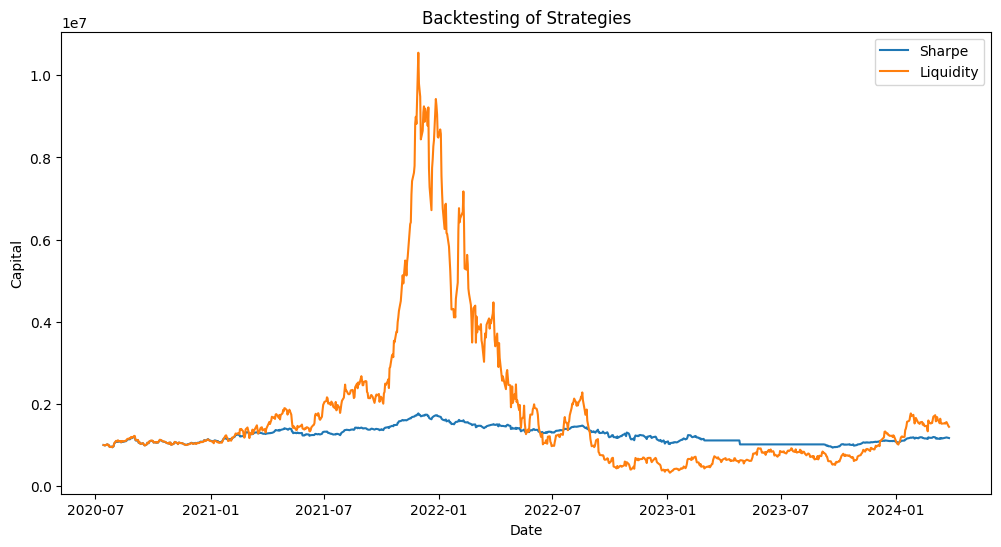

In [41]:
plot_backtesting(history)

In [42]:
fee

{'Sharpe Fee': 20709.515903033862, 'Liquidity Fee': 9786.338145413143}

In [43]:
history

,Sharpe,Liquidity
Date,,
2020-07-14,"1,000,000.0000","1,000,000.0000"
2020-07-15,"997,134.3497","997,434.1161"
2020-07-16,"989,955.7959","989,764.4960"
2020-07-17,"994,317.8250","994,615.4251"
2020-07-20,"1,015,974.1216","1,017,691.1819"
...,...,...
2024-03-20,"1,175,899.6089","1,520,713.0112"
2024-03-21,"1,183,307.3543","1,547,499.0642"
2024-03-22,"1,184,627.5789","1,558,609.0209"
